In [1]:
# import
from shapely.ops import cascaded_union  # , unary_union
import matplotlib.pyplot as plt
import tempfile
import urllib
import base64
import h3
from shapely.geometry import mapping
from geopandas import GeoDataFrame
import xarray as xr
import geopandas
import rtree
import shapely
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import matplotlib
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#Functions


def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col, edgecolors='none',
                    colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])


def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(
        lambda x: h3.h3_to_parent(x, coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[
        [metric_col, ]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfc


def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]]
    dfk.index = dfk[hex_col]
    dfs = (dfk[hex_col]
           .apply(lambda x: pd.Series(list(h3.k_ring(x, k)))).stack()
           .to_frame('hexk').reset_index(1, drop=True).reset_index()
           .merge(df[[hex_col, metric_col]]).fillna(0)
           .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
           .reset_index()
           .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]

    # weighted smoothing
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col, inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K = len(coef)-1
    for k in range(1, K+1):
        temp2.append((df_agg['hexk']
                      .apply(lambda x: pd.Series(list(h3.hex_ring(x, k)))).stack()
                      .to_frame('hexk').reset_index(1, drop=True).reset_index()
                      ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x: coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(
        index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


In [2]:
import numpy as np

# 读取数据
lu_data = xr.open_rasterio(r"F:\Download\南京市\南京市clcd.tif")

# 获取数据维度
if len(lu_data.shape) == 1:
    height, width = lu_data.shape[0], 1
else:
    height, width = lu_data.shape[-2:]

# 选择像元值为 5 的数据
mask = np.where(lu_data.values == 5, True, False)
mask = xr.DataArray(mask, dims=lu_data.dims)
selected_data = lu_data.where(mask, drop=True)

df = (selected_data
      .sel(band=1)
      .to_pandas()
      .stack()
      .reset_index()
      .rename(columns={'x': 'lng', 'y': 'lat', 0: 'water'}))

# 可视化所选的数据
# selected_data.plot.imshow(figsize=(5, 5), cmap='Set1')
# print(selected_data)
# plot_scatter(df, metric_col='water', marker='.',
#              colormap='gray', figsize=(5, 5))


Text(0.5, 1.0, '南京市水系')

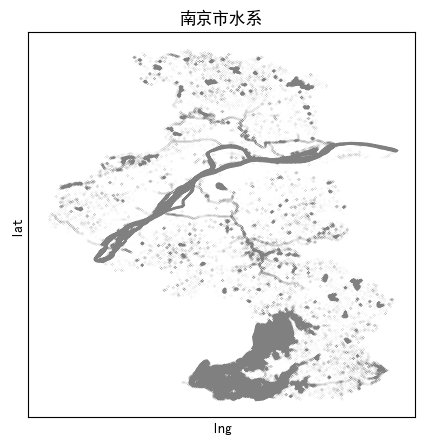

In [3]:
# Visualize the elevation
# ignore the missing values
# df = df[df.water > -1000]


# plot_scatter(df, metric_col='water', marker='.',
#              colormap='gray', figsize=(5, 5))

df.plot.scatter(x='lng', y='lat', marker='.', s=0.0001, colormap='gray', edgecolors='gray', figsize=(5, 5), alpha=1)
plt.xticks([], [])
plt.yticks([], [])
plt.title('南京市水系')

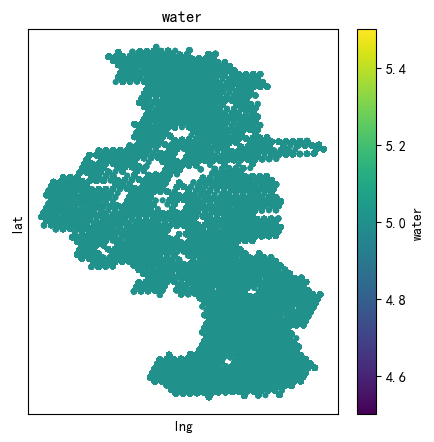

In [10]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)

# calculate elevation average per hex
# df_dem = df.groupby(hex_col)['water'].mean().to_frame(
#     'elevation').reset_index()

#find center of hex for visualization
df['lat'] = df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df['lng'] = df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# plot the hexes
plot_scatter(df, metric_col='water', marker='o', figsize=(5, 5))



Text(0.5, 1.0, '南京市水系栅格')

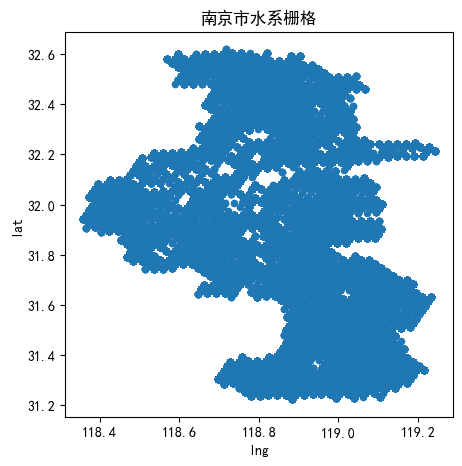

In [7]:
df.plot.scatter(x='lng', y='lat', marker='o', s=0.0001,
                    figsize=(5, 5))
plt.title('南京市水系栅格')
# plt.xticks([], [])
# plt.yticks([], [])


In [8]:
df

,lat,lng,water,hex7
0,32.602540,118.710216,5.0,873091921ffffff
1,32.602540,118.710216,5.0,873091921ffffff
2,32.602540,118.710216,5.0,873091921ffffff
3,32.619716,118.717729,5.0,8730952d2ffffff
4,32.619716,118.717729,5.0,8730952d2ffffff
...,...,...,...,...
952392,31.224285,118.883396,5.0,873093315ffffff
952393,31.224285,118.883396,5.0,873093315ffffff
952394,31.224285,118.883396,5.0,873093315ffffff
952395,31.224285,118.883396,5.0,873093315ffffff
